In [2]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.utils import shuffle
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

In [3]:
def initialize_parameters(n_components, n_features, first_points=None, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    
    pi = np.ones(n_components) / n_components
    
    if first_points is not None:
        mu_k = first_points + np.random.randn(n_components, n_features) * 2.0
    else:
        mu_k = np.random.randn(n_components, n_features) * 5.0
    
    sigma_k = np.array([
        np.eye(n_features) * (2.0 + 0.5 * k) 
        for k in range(n_components)
    ])
    
    return pi, mu_k, sigma_k

def compute_responsibility(x_i, pi, mu_k, sigma_k):
    n_components = len(pi)
    probs = np.zeros(n_components)
    
    distances = np.array([np.sum((x_i - mu_k[k])**2) for k in range(n_components)])
    
    for k in range(n_components):
        try:
            probs[k] = pi[k] * multivariate_normal.pdf(x_i, mean=mu_k[k], cov=sigma_k[k])
        except np.linalg.LinAlgError:
            sigma_k[k] = np.eye(len(x_i)) * np.trace(sigma_k[k]) / len(x_i)
            probs[k] = pi[k] * multivariate_normal.pdf(x_i, mean=mu_k[k], cov=sigma_k[k])
    
    probs += 1e-10
    
    gamma = probs / probs.sum()

    gamma = gamma ** 2
    gamma = gamma / gamma.sum()
    
    # Ensure no component gets too dominant
    if np.max(gamma) > 0.9:
        gamma = np.clip(gamma, 0.1, 0.9)
        gamma = gamma / gamma.sum()
    
    return gamma
    

def update_parameters(x_i, gamma, pi, mu_k, sigma_k, N_k, step_size, t):
    n_components = len(pi)
    n_features = len(x_i)
    min_covar = 1e-6
    
    N_k = (1 - step_size) * N_k + step_size * gamma
    pi = N_k / N_k.sum()
    distances = np.array([np.sum((x_i - mu_k[k])**2) for k in range(n_components)])
    max_dist = np.max(distances)
    
    for k in range(n_components):
        delta = x_i - mu_k[k]
        
        distance_factor = 1.0 / (1.0 + distances[k]/max_dist)
        effective_rate = step_size * distance_factor
        
        if gamma[k] > 0.1:
            mu_k[k] += effective_rate * gamma[k] * delta
    
    for k in range(n_components):
        delta = x_i - mu_k[k]
        delta_out = np.outer(delta, delta)
        
        distance_factor = 1.0 / (1.0 + distances[k]/max_dist)
        effective_rate = step_size * distance_factor
        
        if gamma[k] > 0.1:
            sigma_k[k] = (1 - effective_rate) * sigma_k[k] + \
                         effective_rate * gamma[k] * delta_out
            
            # Ensure positive definiteness
            sigma_k[k] = (sigma_k[k] + sigma_k[k].T) / 2
            eigvals, eigvecs = np.linalg.eigh(sigma_k[k])
            eigvals = np.maximum(eigvals, min_covar)
            sigma_k[k] = eigvecs @ np.diag(eigvals) @ eigvecs.T
    
    return pi, mu_k, sigma_k, N_k

def online_gmm(data_generator, n_components, n_features, n_iterations, alpha=0.6, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    
    first_points = np.array([next(data_generator) for _ in range(n_components)])

    # Initialize parameters
    pi, mu_k, sigma_k = initialize_parameters(n_components, n_features, first_points, random_state)
    N_k = np.ones(n_components) / n_components
    history_mu = []
    
    for t in range(n_iterations):
        x_i = next(data_generator)
        
        step_size = (t + 2) ** -alpha
        
        gamma = compute_responsibility(x_i, pi, mu_k, sigma_k)
        pi, mu_k, sigma_k, N_k = update_parameters(x_i, gamma, pi, mu_k, sigma_k, N_k, step_size, t)
        history_mu.append(mu_k.copy())
        
        if t % 50 == 0:
            if np.max(N_k) > 0.8 or np.min(N_k) < 0.2:
                N_k = np.ones(n_components) / n_components
                pi = N_k.copy()
    
    return pi, mu_k, sigma_k, history_mu

def data_generator(X):
    idx = 0
    n_samples = len(X)
    while idx < n_samples:
        yield X[idx]
        idx += 1


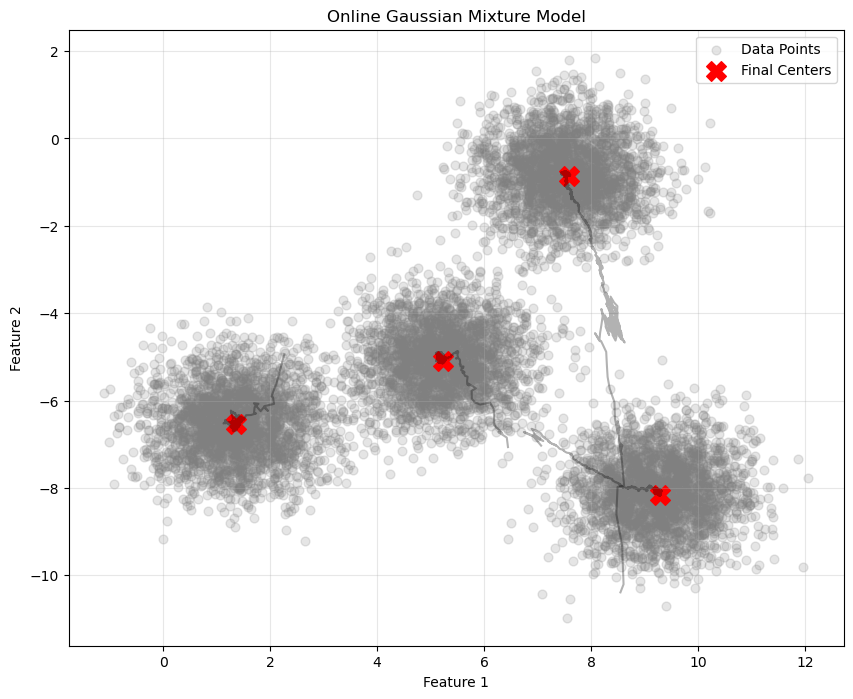

In [4]:
if __name__ == "__main__":
    n_samples = 10000
    n_components = 4
    n_features = 2
    X, y_true = make_blobs(n_samples=n_samples, centers=n_components, 
                          cluster_std=0.80, random_state=1126)
    
    X = shuffle(X, random_state=0)
    gen = data_generator(X)
    
    n_iterations = n_samples - n_components
    alpha = 0.6
    random_state = 1126
    
    pi, mu_k, sigma_k, history_mu = online_gmm(gen, n_components, n_features, 
                                              n_iterations, alpha, random_state)
    
    plt.figure(figsize=(10, 8))
    plt.scatter(X[:, 0], X[:, 1], c='gray', s=40, alpha=0.2, label='Data Points')
    plt.scatter(mu_k[:, 0], mu_k[:, 1], c='red', s=200, marker='X', label='Final Centers')
    history_mu = np.array(history_mu)
    for k in range(n_components):
        plt.plot(history_mu[:, k, 0], history_mu[:, k, 1], 'k-', alpha=0.3)
    
    plt.title('Online Gaussian Mixture Model')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [5]:
X_6 = np.load('./dataset/6_Gauss_Blobs.npy')

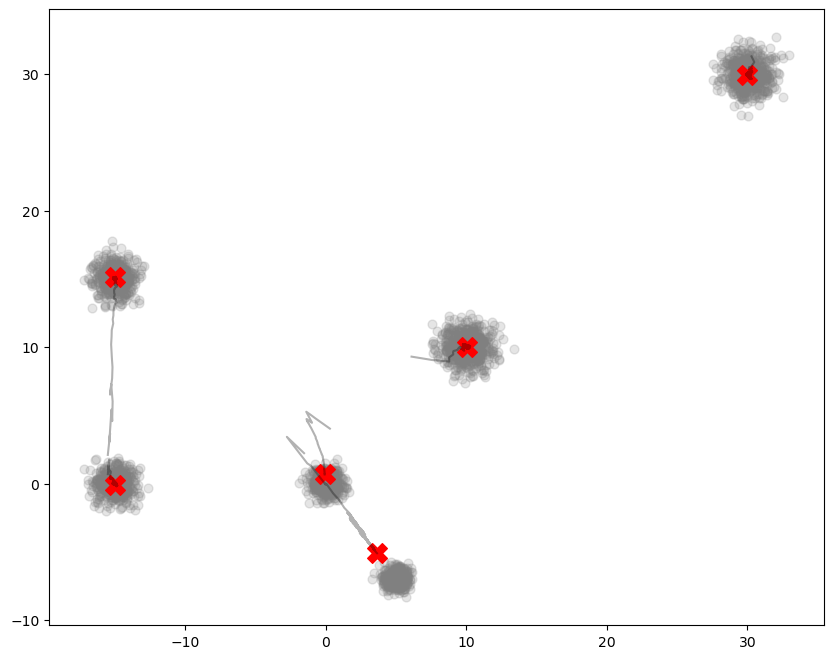

In [6]:
n_samples = len(X_6)
n_components = 6
n_features = 2

gen = data_generator(X_6)
n_iterations = n_samples - n_components
alpha = 0.5
random_state = 42

pi, mu_k, sigma_k, history_mu = online_gmm(gen, n_components, n_features,
                                           n_iterations, alpha, random_state)

plt.figure(figsize=(10, 8))

# Plot data points
plt.scatter(X_6[:, 0], X_6[:, 1], c='gray', s=40, alpha=0.2, label='Data Points')
plt.scatter(mu_k[:, 0], mu_k[:, 1], c='red', s=200, marker='X', label='Final Centers')
history_mu = np.array(history_mu)
for k in range(n_components):
    plt.plot(history_mu[:, k, 0], history_mu[:, k, 1], 'k-', alpha=0.3)



In [220]:
np.save('./mu_k_sEM.npy', history_mu)

In [216]:
X_shift_add = np.load('./dataset/dist_shift_add_gaus.npy')

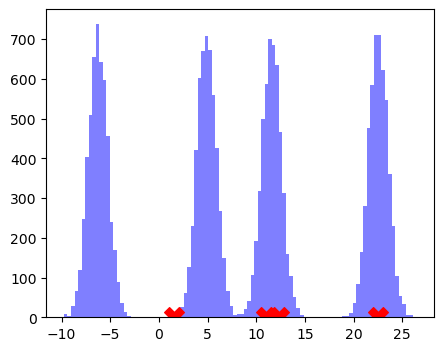

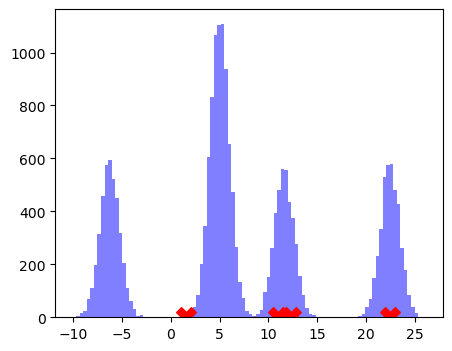

In [ ]:
n_samples = len(X_shift_add)
n_components = 4
n_features = 1

gen = data_generator(X_shift_add)
n_iterations = n_samples - n_components
alpha = 0.5
random_state = 1126

pi, mu_k, sigma_k, history_mu = online_gmm(gen, n_components, n_features,
                                           n_iterations, alpha, random_state)

plt.figure(figsize=(5, 4))

# plot 1d data with histogram
plt.hist(X_shift_add[:len(X_shift_add)//2], bins=100, color='blue', alpha=0.5)
plt.scatter(mu_k, np.zeros_like(mu_k), c='red', s=200, marker='X', label='Final Centers')
plt.show();

plt.figure(figsize=(5, 4))
plt.hist(X_shift_add[len(X_shift_add)//2:], bins=100, color='blue', alpha=0.5)
plt.scatter(mu_k, np.zeros_like(mu_k), c='red', s=200, marker='X', label='Final Centers')
plt.show();

In [245]:
mu_k

array([[10.96403091],
       [12.35625843],
       [ 1.57703317],
       [22.5228867 ]])

In [246]:
X_shift_remove = np.load('./dataset/dist_shift_remove_gaus.npy')

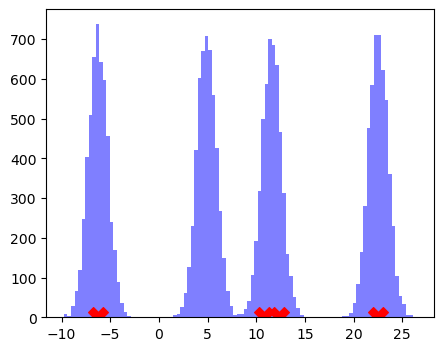

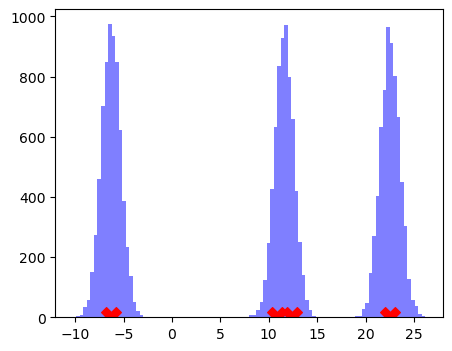

In [ ]:
n_samples = len(X_shift_remove)
n_components = 4
n_features = 1

gen = data_generator(X_shift_remove)
n_iterations = n_samples - n_components
alpha = 0.5
random_state = 1126

pi, mu_k, sigma_k, history_mu = online_gmm(gen, n_components, n_features,
                                           n_iterations, alpha, random_state)

plt.figure(figsize=(5, 4))

# plot 1d data with histogram
plt.hist(X_shift_remove[:len(X_shift_remove)//2], bins=100, color='blue', alpha=0.5)
plt.scatter(mu_k, np.zeros_like(mu_k), c='red', s=200, marker='X', label='Final Centers')
plt.show();

plt.figure(figsize=(5, 4))
plt.hist(X_shift_remove[len(X_shift_remove)//2:], bins=100, color='blue', alpha=0.5)
plt.scatter(mu_k, np.zeros_like(mu_k), c='red', s=200, marker='X', label='Final Centers')
plt.show();

In [248]:
mu_k

array([[10.84672473],
       [12.34331624],
       [-6.24833823],
       [22.46608579]])

In [249]:
shuffled = np.load('./dataset/shuffled.npy')

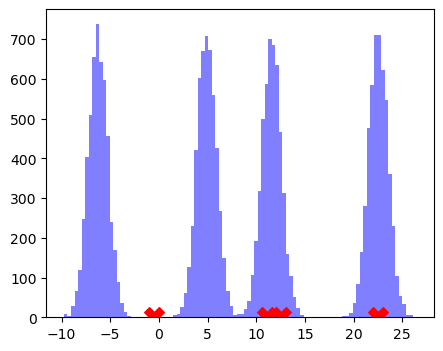

In [ ]:
n_samples = len(shuffled)
n_components = 4
n_features = 1

gen = data_generator(shuffled)
n_iterations = n_samples - n_components
alpha = 0.7
random_state = 0

pi, mu_k, sigma_k, history_mu = online_gmm(gen, n_components, n_features,
                                           n_iterations, alpha, random_state)

plt.figure(figsize=(5, 4))
plt.hist(shuffled, bins=100, color='blue', alpha=0.5)
plt.scatter(mu_k, np.zeros_like(mu_k), c='red', s=200, marker='X', label='Final Centers')
plt.show();

In [251]:
mu_k

array([[12.56999215],
       [11.06986357],
       [-0.54342529],
       [22.52720875]])